<a href="https://colab.research.google.com/github/hoangducnghi2207/DATN/blob/main/Colaboratory_ch%C3%A0o_m%E1%BB%ABng_b%E1%BA%A1n!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import matplotlib.pyplot as plt
import numpy as np


In [8]:
# [0] Libs

import numpy as np

# [1] TSP

"""
    Get data from a given TSP file and convert it into a dictionary
    @arg
        {string} tsp    -- The TSP file src

    @return
        {dictionary}    -- The TSP file as dictionary
"""
def getTspData(tsp):
    # Open input file
    infile = open(tsp, 'r')

    # Read instance
    name = infile.readline().strip().split()[1]                     # NAME
    type = infile.readline().strip().split()[1]                     # TYPE
    comment = infile.readline().strip().split()[1]                  # COMMENT
    dimension = infile.readline().strip().split()[1]                # DIMENSION
    edge_weight_type = infile.readline().strip().split()[1]         # EDGE_WEIGHT_TYPE
    node_coord_section = []                                         # NODE_COORD_SECTION
    infile.readline()

    # Read node coord section and store its x, y coordinates
    for i in range(0, int(dimension)):
        x, y = infile.readline().strip().split()[1:]
        node_coord_section.append([float(x), float(y)])

    # Close input file
    infile.close()

    # File as dictionary
    return {
        'name': name,
        'type': type,
        'comment': comment,
        'dimension': dimension,
        'edge_weight_type': edge_weight_type,
        'node_coord_section': node_coord_section
    }

"""
    Display headers from a given dictionary gotten from a TSP file
    @arg
        {dictionary} dict   -- TSP to dict converted
"""
def displayTspHeaders(dict):
    print('\nName: ', dict['name'])
    print('Type: ', dict['type'])
    print('Comment: ', dict['comment'])
    print('Dimension: ', dict['dimension'])
    print('Edge Weight Type: ', dict['edge_weight_type'], '\n')

# [2] ACO

"""
    Run Ant Colony Optimization (ACO) algorithm for a given Symmetric traveling salesman problem (TSP) space and data
    @arg
        {numpy.ndarray} space           -- The space
        {int} iterations {80}           -- Number of iterations (Ending condition)
        {int} colony {50}               -- Number of ants in the colony
        {float} alpha {1.0}             -- Alpha algorithm parameter, more or less weight to a selected distance
        {float} beta {1.0}              -- Beta algorithm parameter, more or less weight to a selected distance
        {float} del_tau {1.0}           -- Delta Tau algorithm parameter, pheromones releasing rate
        {float} rho {0.5}               -- Rho algorithm parameter, pheromones evaporation rate

    @return
        {Tuple(numpy.ndarray, float)}   -- Indexes of the minimun distance path and the minimun distance
"""
def runAcoTsp(space, iterations = 80, colony = 50, alpha = 1.0, beta = 1.0, del_tau = 1.0, rho = 0.5):
    # [1] Find inverted distances for all nodes
    inv_distances = inverseDistances(space)

    # Add beta algorithm parameter to inverted distances
    inv_distances = inv_distances ** beta

    # Empty pheromones trail
    pheromones = np.zeros((space.shape[0], space.shape[0]))

    # Empty minimum distance and path
    min_distance = None
    min_path = None

    # [2] For the number of iterations
    for i in range(iterations):
        # Initial random positions
        positions = initializeAnts(space, colony)

        # Complete a path
        paths = moveAnts(space, positions, inv_distances, pheromones, alpha, beta, del_tau)

        # Evaporate pheromones
        pheromones *= (1 - rho)

        # [3] For each path
        for path in paths:
            # Empty distance
            distance = 0

            # For each node from second to last
            for node in range(1, path.shape[0]):
                # Calculate distance to the last node
                distance += np.sqrt(((space[int(path[node])] - space[int(path[node - 1])]) ** 2).sum())

            # Update minimun distance and path if less nor non existent
            if not min_distance or distance < min_distance:
                min_distance = distance
                min_path = path

        # Copy and append first node to end of minimum path to form closed path
        min_path = np.append(min_path, min_path[0])

        # Return tuple
        return (min_path, min_distance)

"""
    Inverse distance - Get an array of inverted distances
    @arg
        {numpy.ndarray} space   -- The space

    @return
        {numpy.ndarray}         -- A space.dimension per space.dimension array of inverse distances
"""
def inverseDistances(space):
    # Empty multidimensional array (matriz) to distances
    distances = np.zeros((space.shape[0], space.shape[0]))

    # Calculate distance to all nodes to all nodes
    for index, point in enumerate(space):
        distances[index] = np.sqrt(((space - point) ** 2).sum(axis = 1))

    # Floating-point error handling - Setted to known state
    with np.errstate(all = 'ignore'):
        # Invert the distances
        inv_distances = 1 / distances

    # Replace infinity by zero to prevent zero division error
    inv_distances[inv_distances == np.inf] = 0

    # Eta algorithm result, inverted distances
    return inv_distances

"""
    Initialize ants - Get an array of random initial positions of the ants in space
    @arg
        {numpy.ndarray} space   -- The space
        {int} colony            -- Number of ants in the colony

    @return
        {numpy.ndarry}          -- An array of indexes of initial positions of ants in the space
"""
def initializeAnts(space, colony):
    # Indexes of initial positions of ants
    return np.random.randint(space.shape[0], size = colony)

"""
    Move ants - Move ants from initial positions to cover all nodes
    @arg
        {numpy.ndarray} space           -- The space
        {numpy.ndarray} positions       -- Indexes of initial positions of ants in the space
        {numpy.ndarray} inv_distances   -- Inverted distances ^ beta
        {numpy.ndarray} pheromones      -- Tau, pheromones trail
        {float} alpha                   -- Alpha algorithm parameter, more or less weight to a selected distance
        {float} beta                    -- Beta algorithm parameter, more or less weight to a selected distance
        {float} del_tau                 -- Delta Tau algorithm parameter, pheromones releasing rate

    @return
        {numpy.ndarry}                  -- Indexes of the paths taken by the ants
"""
def moveAnts(space, positions, inv_distances, pheromones, alpha, beta, del_tau):
    # Empty multidimensional array (matriz) to paths
    paths = np.zeros((space.shape[0], positions.shape[0]), dtype = int) - 1

    # Initial position at node zero
    paths[0] = positions

    # For nodes after start to end
    for node in range(1, space.shape[0]):
        # For each ant
        for ant in range(positions.shape[0]):
            # Probability to travel the nodes
            next_location_probability = (inv_distances[positions[ant]] ** alpha + pheromones[positions[ant]] ** beta /
                                            inv_distances[positions[ant]].sum() ** alpha + pheromones[positions[ant]].sum() ** beta)

            # Index to maximum probability node
            next_position = np.argwhere(next_location_probability == np.amax(next_location_probability))[0][0]

            # Check if node has already been visited
            while next_position in paths[:, ant]:
                # Replace the probability of visited to zero
                next_location_probability[next_position] = 0.0

                # Find the maximum probability node
                next_position = np.argwhere(next_location_probability == np.amax(next_location_probability))[0][0]

            # Add node to path
            paths[node, ant] = next_position

            # Update pheromones (releasing pheromones)
            pheromones[node, next_position] = pheromones[node, next_position] + del_tau

    # Paths taken by the ants
    return np.swapaxes(paths, 0, 1)

In [10]:
# Get TSP data
TSP = getTspData('/content/drive/MyDrive/data.tsp')

# Display TSP file headers
displayTspHeaders(TSP)



Name:  kroA100
Type:  TSP
Comment:  300-city
Dimension:  300
Edge Weight Type:  EUC_2D 



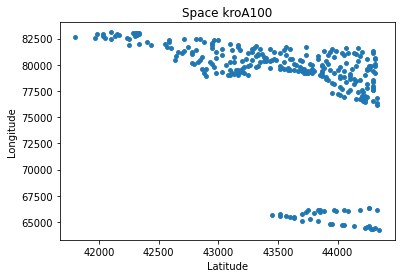

In [11]:
# Get Space
space = np.array(TSP['node_coord_section'])

# Plot nodes
plt.scatter(space[:, 0], space[:, 1], s = 15)

# Plot properties
plt.title('Space {}'.format(TSP['name']))
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show plot
plt.show()
plt.close()

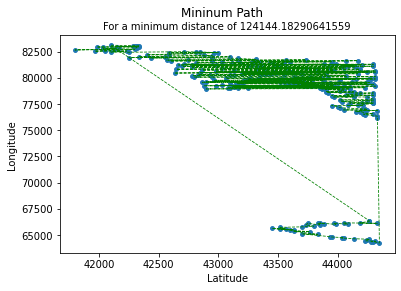

In [12]:
# Run ACO
min_path, min_distance = runAcoTsp(space)

# Plot path
plt.scatter(space[:, 0], space[:, 1], marker='o', s=15)
plt.plot(space[min_path, 0], space[min_path, 1], c='g', linewidth=0.8, linestyle="--")

# Plot properties
plt.suptitle('Mininum Path')
plt.title('For a minimum distance of {}'.format(min_distance), fontsize = 10)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show plot
plt.show()
plt.close()